# Second Competition: Modulation format classification

In [208]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import h5py

#import library
from nn_helper_func import *

Load datasets. They are stored as a pickle file.

The datasets are taken from https://www.deepsig.io/datasets (RML2016.10a.tar.bz2), which contains a variety of radio datasets that are available as open datasets. The (simplified and modified, already pre-processed) dataset contains traces of 128 complex samples (Inphase and Quadrature component) of received radio signals with different modulation formats and at different signal-to-noise ratios (SNRs). The goal is to estimate the modulation format and/or the SNR from the traces.

In [209]:
# Load training dataset
with open('Deepsig_dataset_train.pkl', "rb") as f:
    X_train = pickle.load(f)
    y_train = pickle.load(f)
    SNR_train = pickle.load(f)
    modulation_formats = pickle.load(f)
    
# Load validation dataset
with open('Deepsig_dataset_valid.pkl', "rb") as f:
    X_valid = pickle.load(f)
    y_valid = pickle.load(f)
    SNR_valid = pickle.load(f)    

Print modulation formats that are used:

In [210]:
print('Modulation formats: ', modulation_formats)

Modulation formats:  ['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']


The array `X_train` contains the traces (the examples). The corresponding labels (the modulation format) are given by `y_train` and the corresponding SNR is given in `SNR_train`. The label in `y_train` corresponds to one of the modulation formats in `modulation_formats`.

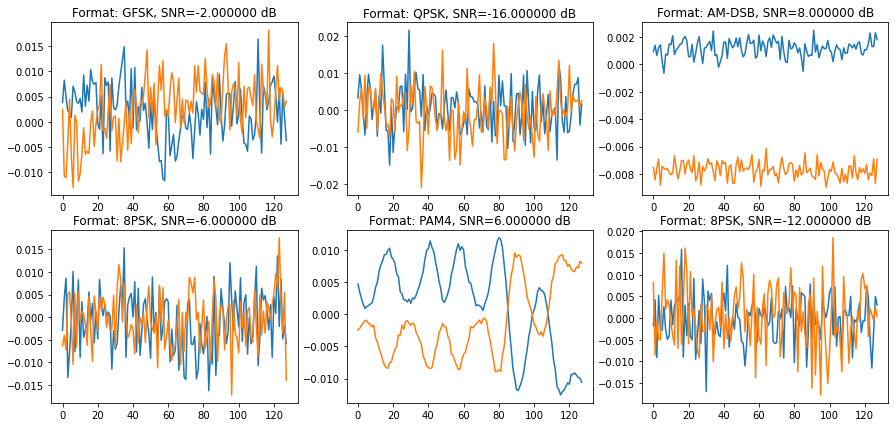

In [211]:
# plot 6 consecutive signal traces
starti = np.random.randint(0,X_train.shape[0]-7)
plt.figure(figsize=(15,7))
for k in range(6):
    plt.subplot(2,3,k+1)
    plt.plot(np.real(X_train[k+starti,:]))
    plt.plot(np.imag(X_train[k+starti,:]))
    plt.title('Format: %s, SNR=%f dB' % (modulation_formats[y_train[k+starti]], SNR_train[k+starti]))

## Task 1: Distinguish between BPSK and GFSK
You are given samples of an unknown modulation format and your task is to determine the modulation format in order to setup the receiver correctly. Try the following two options:
* Carry out the training separately for each SNR value, i.e., have one classifier for every SNR point
* Carry out the training jointly over all SNR values

Show the classification error for the validation set for each SNR point separately.

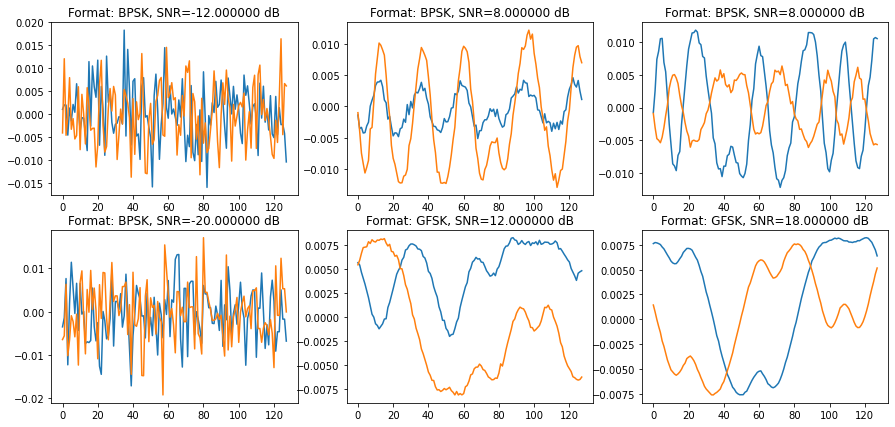

In [212]:
# generate Training set for Task 1
task1_modulation_formatidx = [i for i in range(len(modulation_formats)) if (modulation_formats[i] == 'BPSK' or modulation_formats[i] == 'GFSK')] 

task1_train_idx = [i for i in range(len(y_train)) if (y_train[i] == task1_modulation_formatidx[0] or y_train[i] == task1_modulation_formatidx[1])]
y_train_task1 = y_train[task1_train_idx]
X_train_task1 = X_train[task1_train_idx,:]
SNR_train_task1 = SNR_train[task1_train_idx]

task1_valid_idx = [i for i in range(len(y_valid)) if (y_valid[i] == task1_modulation_formatidx[0] or y_valid[i] == task1_modulation_formatidx[1])]
y_valid_task1 = y_valid[task1_valid_idx]
X_valid_task1 = X_valid[task1_valid_idx,:]
SNR_valid_task1 = SNR_valid[task1_valid_idx]

# plot 6 consecutive signal traces
starti = np.random.randint(0,X_train_task1.shape[0]-7)
plt.figure(figsize=(15,7))
for k in range(6):
    plt.subplot(2,3,k+1)
    plt.plot(np.real(X_train_task1[k+starti,:]))
    plt.plot(np.imag(X_train_task1[k+starti,:]))
    plt.title('Format: %s, SNR=%f dB' % (modulation_formats[y_train_task1[k+starti]], SNR_train_task1[k+starti]))

In [213]:
# write your own classification algorithm here

#first shape the data, convert input data from 128 complex number to 256 real number
#from 128 features to 256 features
X     = np.concatenate((X_train_task1.real,X_train_task1.imag),axis=1).transpose()
X     = X /X.max()                  #normalize the input training X.max()
X_val = np.concatenate((X_valid_task1.real,X_valid_task1.imag),axis=1).transpose()
X_val = X_val/X_val.max()           #normalize the input validation

Y     = np.equal(y_train_task1,4)   #set 0 as BPSK and 1 as GFSK
Y     = Y.astype(float)             #convert data type to float
Y     = Y.reshape(-1,1).transpose() #reshape the array
Y_val = np.equal(y_valid_task1,4)
Y_val = Y_val.astype(float)
Y_val = Y_val.reshape(-1,1).transpose()

X_train_SNR=[]
X_valid_SNR=[]
Y_train_SNR=[]
Y_valid_SNR=[]

#variables
alpha = 0.6                       #learning rate  
num_iteration = 5000               #number of iteration
n_H = 64 #number of hidden layers

#divide the data base on SNR
SNR_range = np.unique(SNR_train_task1) #range of SNR from -20 to 18dB
Error_rates = np.zeros(len(SNR_range)) #store the value of error rate for every SNR
Error_rates_train = np.zeros(len(SNR_range))

#loop over all SNR value
for idx,value in enumerate(SNR_range):
    #assign indices for every SNR value
    ids_train = [i for (i,val) in enumerate(SNR_train_task1) if np.abs(val-value) < 0.01]
    ids_valid = [i for (i,val) in enumerate(SNR_valid_task1) if np.abs(val-value) < 0.01]
    #divide data according to its SNR value
    X_train_SNR = X[:,ids_train]
    X_valid_SNR = X_val[:,ids_valid]
    Y_train_SNR = Y[:,ids_train]
    Y_valid_SNR = Y_val[:,ids_valid]
    
    #feed the data to Neural Network model
    params = Neural_Network_model(X_train_SNR,Y_train_SNR,n_H,alpha,num_iteration)
    #make a prediction    
    Y_pred_train = make_prediction(X_train_SNR,params)
    Y_pred = make_prediction(X_valid_SNR,params)    
    
    #calculate the error for every SNR value
    Error_rates_train[idx] = CER(Y_pred_train,Y_train_SNR)
    Error_rates[idx] = CER(Y_pred,Y_valid_SNR)
    
    
    print("Erorr rate for training set ,SNR "+str(value)+" dB = "+str(Error_rates_train[idx]))
    print("Error rate for validation set ,SNR "+str(value)+" dB = "+str(Error_rates[idx])) 

Cost after iteration 0: 0.707066
Cost after iteration 100: 0.683841
Cost after iteration 200: 0.648726
Cost after iteration 300: 0.595072
Cost after iteration 400: 0.573772
Cost after iteration 500: 0.567495
Cost after iteration 600: 0.565491
Cost after iteration 700: 0.564813
Cost after iteration 800: 0.583086
Cost after iteration 900: 0.564598
Cost after iteration 1000: 0.564529
Cost after iteration 1100: 0.571370
Cost after iteration 1200: 0.564538
Cost after iteration 1300: 0.564357
Cost after iteration 1400: 0.564325
Cost after iteration 1500: 0.564384
Cost after iteration 1600: 0.564740
Cost after iteration 1700: 0.564836
Cost after iteration 1800: 0.564356
Cost after iteration 1900: 0.564104
Cost after iteration 2000: 0.563970
Cost after iteration 2100: 0.563896
Cost after iteration 2200: 0.563969
Cost after iteration 2300: 0.564238
Cost after iteration 2400: 0.563948
Cost after iteration 2500: 0.563459
Cost after iteration 2600: 0.563278
Cost after iteration 2700: 0.563367
Cost

Cost after iteration 1600: 0.582374
Cost after iteration 1700: 0.582261
Cost after iteration 1800: 0.582117
Cost after iteration 1900: 0.581934
Cost after iteration 2000: 0.581739
Cost after iteration 2100: 0.583910
Cost after iteration 2200: 0.581837
Cost after iteration 2300: 0.580711
Cost after iteration 2400: 0.580303
Cost after iteration 2500: 0.581948
Cost after iteration 2600: 0.579443
Cost after iteration 2700: 0.578371
Cost after iteration 2800: 0.578426
Cost after iteration 2900: 0.575535
Cost after iteration 3000: 0.574268
Cost after iteration 3100: 0.570773
Cost after iteration 3200: 0.566892
Cost after iteration 3300: 0.561918
Cost after iteration 3400: 0.555584
Cost after iteration 3500: 0.548123
Cost after iteration 3600: 0.539708
Cost after iteration 3700: 0.530546
Cost after iteration 3800: 0.520815
Cost after iteration 3900: 0.510639
Cost after iteration 4000: 0.500089
Cost after iteration 4100: 0.489196
Cost after iteration 4200: 0.477988
Cost after iteration 4300: 0

Cost after iteration 3200: 0.023804
Cost after iteration 3300: 0.021820
Cost after iteration 3400: 0.020093
Cost after iteration 3500: 0.018581
Cost after iteration 3600: 0.017248
Cost after iteration 3700: 0.016068
Cost after iteration 3800: 0.015018
Cost after iteration 3900: 0.014079
Cost after iteration 4000: 0.013235
Cost after iteration 4100: 0.012474
Cost after iteration 4200: 0.011784
Cost after iteration 4300: 0.011158
Cost after iteration 4400: 0.010587
Cost after iteration 4500: 0.010064
Cost after iteration 4600: 0.009585
Cost after iteration 4700: 0.009144
Cost after iteration 4800: 0.008737
Cost after iteration 4900: 0.008361
Erorr rate for training set ,SNR -4 dB = 0.0
Error rate for validation set ,SNR -4 dB = 0.49101796407185627
Cost after iteration 0: 0.825227
Cost after iteration 100: 0.687614
Cost after iteration 200: 0.669873
Cost after iteration 300: 0.637998
Cost after iteration 400: 0.596905
Cost after iteration 500: 0.537572
Cost after iteration 600: 0.464181
C

Erorr rate for training set ,SNR 4 dB = 0.0
Error rate for validation set ,SNR 4 dB = 0.5290322580645161
Cost after iteration 0: 0.866754
Cost after iteration 100: 0.683434
Cost after iteration 200: 0.664048
Cost after iteration 300: 0.637194
Cost after iteration 400: 0.587130
Cost after iteration 500: 0.522166
Cost after iteration 600: 0.466358
Cost after iteration 700: 0.396836
Cost after iteration 800: 0.342421
Cost after iteration 900: 0.303336
Cost after iteration 1000: 0.260211
Cost after iteration 1100: 0.217464
Cost after iteration 1200: 0.185075
Cost after iteration 1300: 0.159829
Cost after iteration 1400: 0.139455
Cost after iteration 1500: 0.123277
Cost after iteration 1600: 0.110248
Cost after iteration 1700: 0.099300
Cost after iteration 1800: 0.089709
Cost after iteration 1900: 0.081087
Cost after iteration 2000: 0.073234
Cost after iteration 2100: 0.066046
Cost after iteration 2200: 0.059481
Cost after iteration 2300: 0.053535
Cost after iteration 2400: 0.048222
Cost af

Cost after iteration 1500: 0.167423
Cost after iteration 1600: 0.150669
Cost after iteration 1700: 0.136317
Cost after iteration 1800: 0.123312
Cost after iteration 1900: 0.111092
Cost after iteration 2000: 0.099542
Cost after iteration 2100: 0.088774
Cost after iteration 2200: 0.078970
Cost after iteration 2300: 0.070291
Cost after iteration 2400: 0.062795
Cost after iteration 2500: 0.056408
Cost after iteration 2600: 0.050988
Cost after iteration 2700: 0.046372
Cost after iteration 2800: 0.042412
Cost after iteration 2900: 0.038982
Cost after iteration 3000: 0.035982
Cost after iteration 3100: 0.033333
Cost after iteration 3200: 0.030975
Cost after iteration 3300: 0.028861
Cost after iteration 3400: 0.026957
Cost after iteration 3500: 0.025234
Cost after iteration 3600: 0.023669
Cost after iteration 3700: 0.022245
Cost after iteration 3800: 0.020944
Cost after iteration 3900: 0.019755
Cost after iteration 4000: 0.018665
Cost after iteration 4100: 0.017663
Cost after iteration 4200: 0

Plot the classification error for each SNR value

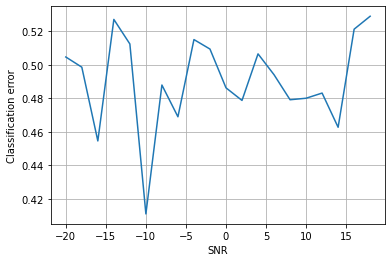

In [217]:
plt.figure(figsize=(6,4))
plt.plot(SNR_range, Error_rates)
plt.xlabel('SNR')
plt.ylabel('Classification error')
plt.grid(which='both')
plt.show()

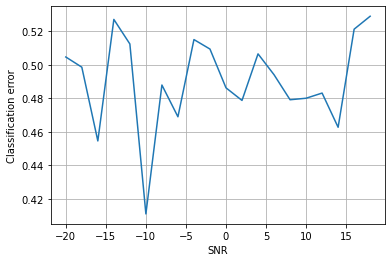

In [215]:


# prepare data, convert complex data to real and imaginary parts
X_train_real = np.column_stack((np.real(X_train_task1), np.imag(X_train_task1)))
X_valid_real = np.column_stack((np.real(X_valid_task1), np.imag(X_valid_task1)))


# generate 0/1 class labels
dic = {task1_modulation_formatidx[0]: 0, task1_modulation_formatidx[1]: 1}
y_train_mod = np.array([dic.get(i) for i in y_train_task1])
y_valid_mod = np.array([dic.get(i) for i in y_valid_task1])


SNR_range = np.unique(SNR_train_task1)
Error_rates = np.zeros(len(SNR_range))

# loop over SNRs
for idx, value in enumerate(SNR_range):
    # pick training and validation examples corresponding to specific SNR
    indices_valid = [i for (i,val) in enumerate(SNR_valid_task1) if np.abs(val-value) < 0.01]
    indices_train = [i for (i,val) in enumerate(SNR_train_task1) if np.abs(val-value) < 0.01]

    # dummy classifier ... return random numbers ... can you do betters?    
    valid_est = np.random.randint(low=0,high=2, size=y_valid_mod[indices_valid].shape)
   
    Error_rates[idx] = CER(valid_est, y_valid_mod[indices_valid])

plt.figure(figsize=(6,4))
plt.plot(SNR_range, Error_rates)
plt.xlabel('SNR')
plt.ylabel('Classification error')
plt.grid(which='both')
plt.show()

In [216]:
# space where you can program your own (better) classifier






## Task 2: Classify modulation format
Design an ML system that estimates the modulation format from the traces (supervised learning, classification task). To evaluate the performance, carry out the classification separately for each SNR and show the performance for each SNR point.
* Carry out the training separately for each SNR value, i.e., have one classifier for every SNR point
* Carry out the training jointly over all SNR values

## Task 2: Determine SNR
Determine the SNR from the examples (supervised learning, classification task)

## Task 3: Cluster the traces
Try if clustering is successful and if you can group examples that share similar properties (e.g., modulation format and SNR)